In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import torch.optim as optim

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
cuda:0


In [0]:

batch_size_train = 64
batch_size_test = 1000

MNIST_training = torchvision.datasets.MNIST('/content/drive/My Drive/HIP2019/MNIST_dataset/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.0,), (1.0,))]))

MNIST_test_set = torchvision.datasets.MNIST('/content/drive/My Drive/HIP2019/MNIST_dataset/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.0,), (1.0,))]))

# create a training and a validation set
MNIST_training_set, MNIST_validation_set = random_split(MNIST_training, [55000, 5000])


train_loader = torch.utils.data.DataLoader(MNIST_training_set,batch_size=batch_size_train, shuffle=True)

validation_loader = torch.utils.data.DataLoader(MNIST_validation_set,batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(MNIST_test_set,batch_size=batch_size_test, shuffle=True)

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.dtype)
print(example_targets.dtype)

torch.float32
torch.int64


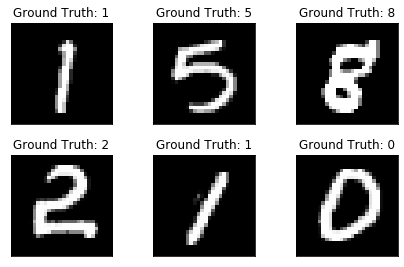

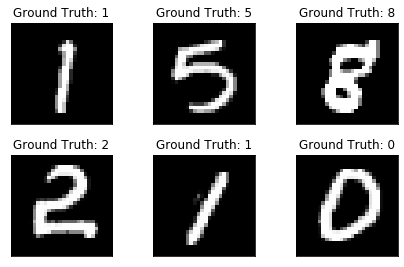

In [4]:

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [0]:
# Fully Connected AutoEncoder Architecture
class AE(torch.nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 300, True)
        self.fc2 = torch.nn.Linear(300, 150, True)
        self.fc3 = torch.nn.Linear(150, 300, True)
        self.fc4 = torch.nn.Linear(300,28*28, True)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = x.view(x.size(0), 1, 28, 28)
        return x

In [0]:
# Fully Convolutional AutoEncoder Architecture
class ConvAE(torch.nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5,padding=2)
        self.conv2 = torch.nn.Conv2d(6, 16, kernel_size=5,padding=2)
        self.conv3 = torch.nn.Conv2d(16, 6, kernel_size=5,padding=2)
        self.conv4 = torch.nn.Conv2d(6, 1, kernel_size=5,padding=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.sigmoid(self.conv4(x))
        return x

In [0]:
n_epochs=10
train_losses = []
train_counter = []
validation_losses = []
validation_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [0]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = network(data)
    loss = F.mse_loss(output, data)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/drive/My Drive/HIP2019/MNIST_NN_results/model.pth')
      torch.save(optimizer.state_dict(), '/content/drive/My Drive/HIP2019/MNIST_NN_results/optimizer.pth')

In [0]:
def validation():
  network.eval()
  validation_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in validation_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      validation_loss += F.mse_loss(output, data).item()
  validation_loss /= len(validation_loader.dataset)
  validation_losses.append(validation_loss)
  print('\nValidation set: Avg. loss: {:.6f}\n'.format(validation_loss))

In [0]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += F.mse_loss(output, data).item()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.6f}\n'.format(test_loss))

In [13]:

log_interval = 200
learning_rate=0.001
n_epochs = 10

#network = AE().to(device)
network = ConvAE().to(device)


optimizer = optim.Adam(network.parameters(), lr=learning_rate, amsgrad=True)

validation()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  validation()
test()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Validation set: Avg. loss: 0.003664

Train Epoch: 1 [0/55000 (0%)]	Loss: 0.232231
Train Epoch: 1 [12800/55000 (23%)]	Loss: 0.004088
Train Epoch: 1 [25600/55000 (47%)]	Loss: 0.001994
Train Epoch: 1 [38400/55000 (70%)]	Loss: 0.001381
Train Epoch: 1 [51200/55000 (93%)]	Loss: 0.000979

Validation set: Avg. loss: 0.000016

Train Epoch: 2 [0/55000 (0%)]	Loss: 0.001015
Train Epoch: 2 [12800/55000 (23%)]	Loss: 0.000851
Train Epoch: 2 [25600/55000 (47%)]	Loss: 0.000796
Train Epoch: 2 [38400/55000 (70%)]	Loss: 0.000683
Train Epoch: 2 [51200/55000 (93%)]	Loss: 0.000705

Validation set: Avg. loss: 0.000012

Train Epoch: 3 [0/55000 (0%)]	Loss: 0.000775
Train Epoch: 3 [12800/55000 (23%)]	Loss: 0.000612
Train Epoch: 3 [25600/55000 (47%)]	Loss: 0.000630
Train Epoch: 3 [38400/55000 (70%)]	Loss: 0.000552
Train Epoch: 3 [51200/55000 (93%)]	Loss: 0.000508

Validation set: Avg. loss: 0.000008

Train Epoch: 4 [0/55000 (0%)]	Loss: 0.000530
Train Epoch: 4 [12800/55000 (23%)]	Loss: 0.000503
Train Epoch: 4 [25

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


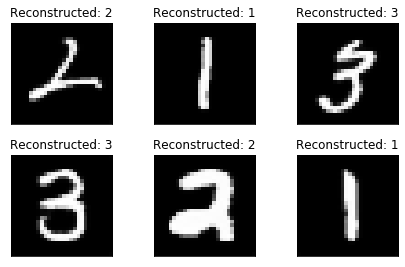

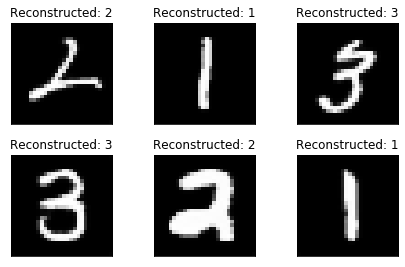

In [18]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

recons_data = network(example_data.to(device)).cpu().detach().numpy()

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recons_data[i][0], cmap='gray', interpolation='none')
  plt.title("Reconstructed: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig